In [60]:
import copy
import easydict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

from skimage.exposure import exposure
from skimage.feature import hog

import numpy as np
import matplotlib.pyplot as plt


# PreParing Data

In [39]:
# Data transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.255]

data_transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        # transforms.Grayscale(num_output_channels=3)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        # transforms.Grayscale(num_output_channels=3)
    ])
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [40]:
# Loading Datasets
datasets = {
    'train': torchvision.datasets.CIFAR10(root='./data', train=True, transform=data_transform['train'],
                                          download=True),
    'val': torchvision.datasets.CIFAR10(root='./data', train=False, transform=data_transform['val'],
                                        download=True)
}

# Defining class names
class_names = datasets['train'].classes
print(f'Class names are {class_names}')

# Creating DataLoaders
batch_size = 1
dataloaders = {x: torch.utils.data.DataLoader(dataset=datasets[x], batch_size=batch_size, shuffle=False, num_workers=2) for x in
               ['train', 'val']}

print('DataLoaders Are Ready.')

Files already downloaded and verified
Files already downloaded and verified
Class names are ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
DataLoaders Are Ready.


# Extracting HOG Features and Making New Datasets

In [41]:
import datetime

orientations = 8
pixels_per_cell = (8, 8)
cells_per_block = (1, 1)
block_norm = 'L2-Hys'

# Make HOG features dataset 
def extract_hog_features(image):
    hog_channels = []
    for channel in range(image.shape[0]):  
        # Extract the single channel
        single_channel = image[channel, :, :].cpu().numpy()

        # Extract HOG features for the single channel and rescale features 
        fd, hog_channel = hog(single_channel,
                              orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              visualize=True)
        hog_channel = exposure.rescale_intensity(hog_channel, in_range=(0, 10))
        hog_channels.append(hog_channel)

    # Stack the HOG images to form a 3-channel image
    hog_image = np.stack(hog_channels, axis=0)
    return torch.tensor(hog_image, dtype=torch.float32)

# Define HOG extracted datasets
hog_datasets = {
    'train': None,
    'val': None
}

# Set number of new dataset images to Subset from original dataset
datasets_length = 1000

# Iterating over two datasets
for phase in ['train', 'val']:
    # Set timer for extracting HOG
    s0 = datetime.datetime.now()
    print(f'start HOG extracting form {phase} images in: {s0}')

    # Define lists for hog features 
    hog_images = []
    labels = []
    
    # define counter for datasets length
    counter = 0
    
    # Iterating over batches and data for HOG feature extraction
    for image, label in dataloaders[phase]:
        # Extract HOG features for each image
        hog_image = extract_hog_features(image.squeeze())  # Squeeze in case the batch size is 1
        hog_images.append(hog_image)
        labels.append(label)
        
        # check counter for length
        counter += 1
        if counter > datasets_length:
            break

    # Convert lists of tensors to a single tensor   
    hog_dataset = torch.stack(hog_images)
    labels = torch.cat(labels)
        
    # Create a new dataset with HOG images and labels
    hog_datasets[phase] = TensorDataset(hog_dataset, labels)
    print(f'Extracting Done in: {datetime.datetime.now() - s0}')


print(len(hog_datasets['train']))
print(len(hog_datasets['val']))

start HOG extracting form train images in: 2024-01-20 18:22:56.945479
Extracting Done in 0:05:46.783232
start HOG extracting form val images in: 2024-01-20 18:28:43.728711
Extracting Done in 0:06:53.145554
1001
1001


In [63]:
# Make new small datasets for comparing HOG vs Original images
indices = list(range(1000))
for dataset in [datasets, hog_datasets]:
    for phase in ['train', 'val']:
        dataset[phase] = Subset(dataset[phase], indices)
    
# Create new small Dataloaders
batch_size = 16
original_dataloaders = {x: torch.utils.data.DataLoader(dataset=datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in
               ['train', 'val']}

hog_dataloaders = {x: torch.utils.data.DataLoader(dataset=hog_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in
               ['train', 'val']}

In [67]:
print(len(datasets['train']))
print(len(datasets['val']))

print(len(hog_datasets['train']))
print(len(hog_datasets['val']))

1000
1000
1000
1000


# Setup pretrained model

In [68]:
# Load pretrained model
pretrained_model = models.resnet18(pretrained=True)

# Freeze all trainable layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modifying last classification layer for our dataset
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)

# print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Defining loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

# Train Function 

In [80]:
# train function 
acc_list = easydict.EasyDict({'train': [], 'val': []})
loss_list = easydict.EasyDict({'train': [], 'val': []})


def train_model(model, criterion, optimizer, model_dataloaders, model_datasets,  epoch_num=25):
    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(model_dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, predictions = torch.max(outputs, 1)
                    
                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
            
            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(model_datasets[phase])
            epoch_accuracy = running_corrects.double() / len(model_datasets[phase])
            
            # Show epoch details
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} / Loss: {epoch_loss:.4f}')
            
            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())  
                print('Best model weights updated!')
                
            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print()
        
    print(f'Best Accuracy: {best_accuracy:.4f}')
    
    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model

In [82]:
model = pretrained_model.to(device)

# Train model
model = train_model(model, criterion, optimizer, original_dataloaders, datasets, epoch_num=30)

Epoch 1/30:
Train Accuracy: 0.7840 / Loss: 0.7414
Val Accuracy: 0.7180 / Loss: 0.8682
Best model weights updated!

Epoch 2/30:
Train Accuracy: 0.7950 / Loss: 0.6904
Val Accuracy: 0.7090 / Loss: 0.8640

Epoch 3/30:
Train Accuracy: 0.8100 / Loss: 0.6411
Val Accuracy: 0.7150 / Loss: 0.8412

Epoch 4/30:
Train Accuracy: 0.8130 / Loss: 0.6229
Val Accuracy: 0.7240 / Loss: 0.8275
Best model weights updated!

Epoch 5/30:
Train Accuracy: 0.8210 / Loss: 0.5999
Val Accuracy: 0.7100 / Loss: 0.8539

Epoch 6/30:
Train Accuracy: 0.8270 / Loss: 0.5837
Val Accuracy: 0.7190 / Loss: 0.8322

Epoch 7/30:
Train Accuracy: 0.8350 / Loss: 0.5525
Val Accuracy: 0.7150 / Loss: 0.8289

Epoch 8/30:
Train Accuracy: 0.8450 / Loss: 0.5278
Val Accuracy: 0.7000 / Loss: 0.8727

Epoch 9/30:
Train Accuracy: 0.8330 / Loss: 0.5456
Val Accuracy: 0.7290 / Loss: 0.8174
Best model weights updated!

Epoch 10/30:
Train Accuracy: 0.8610 / Loss: 0.4974
Val Accuracy: 0.7290 / Loss: 0.8211

Epoch 11/30:
Train Accuracy: 0.8630 / Loss: 0

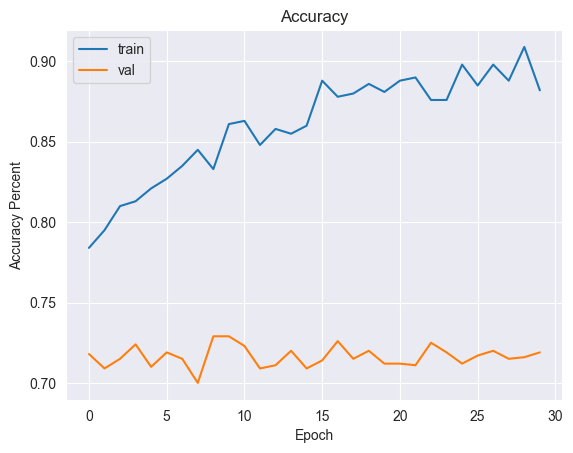

In [83]:
# plot accuracy
plt.plot([a.cpu() for a in acc_list.train], label='train')
plt.plot([a.cpu() for a in acc_list.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

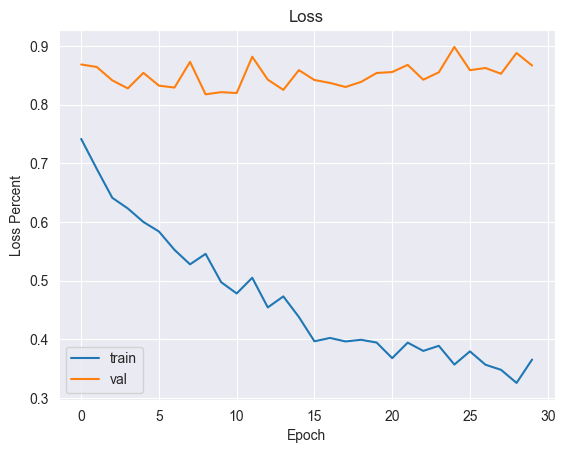

In [84]:
# plot loss
plt.plot([a for a in loss_list.train], label='train')
plt.plot([a for a in loss_list.val], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()

# Plotting Confusion Matrix

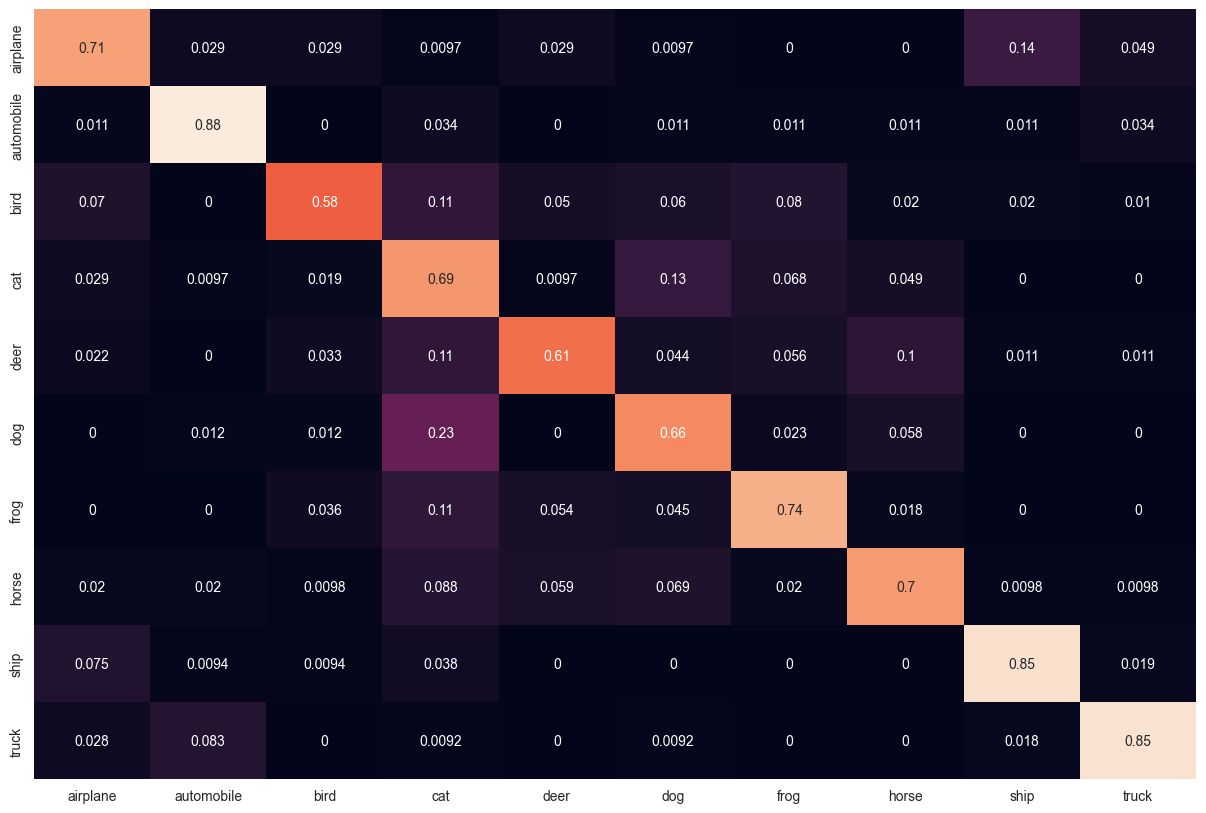

In [85]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


def plot_cm(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in original_dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model(inputs)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cm / np.sum(cm, axis=1)[:, None],
        index=[i for i in class_names],
        columns=[i for i in class_names]
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_cm, annot=True, cbar=False)
    plt.show()


plot_cm(model)


# Visualizing The Predictions

In [90]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(original_dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break

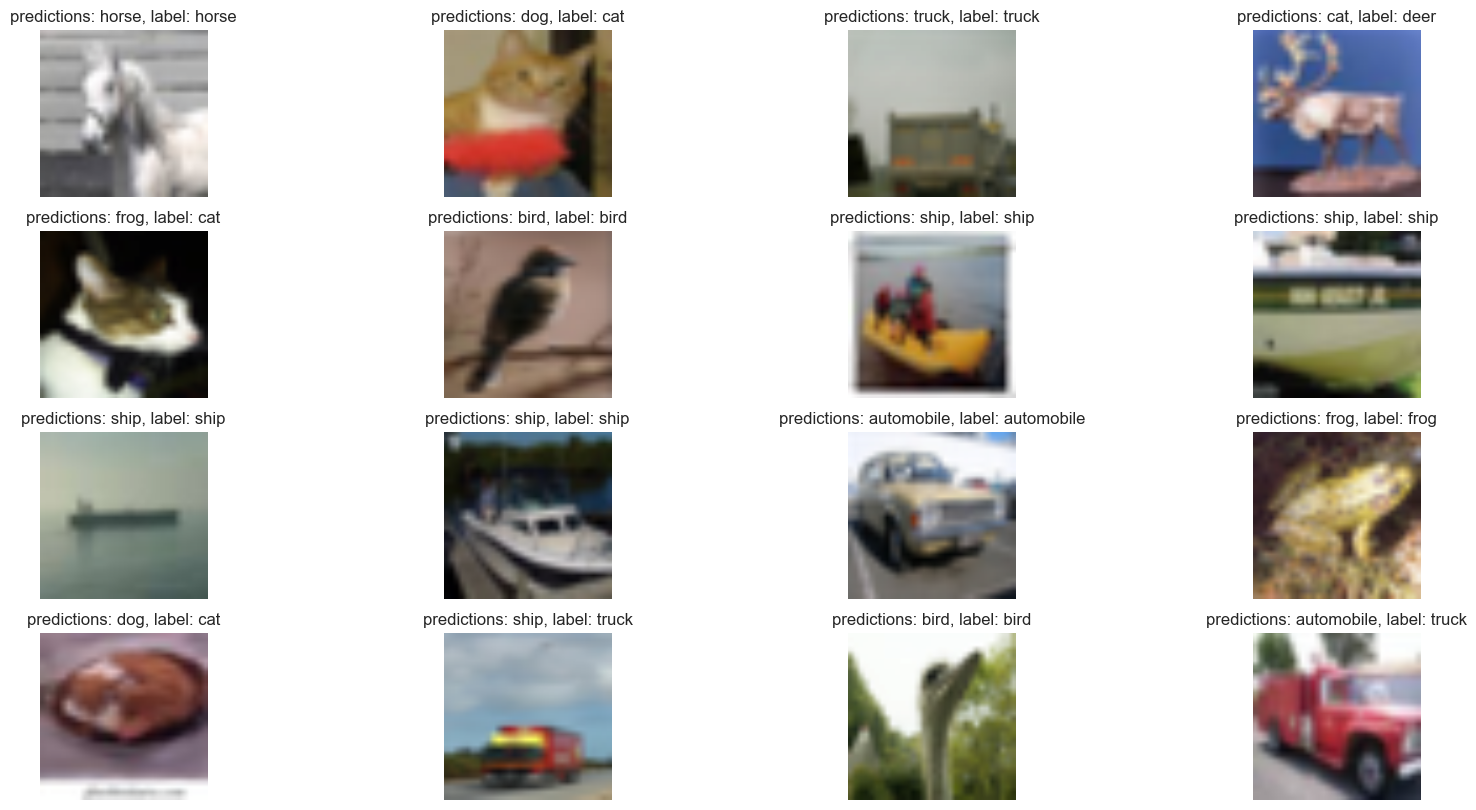

In [91]:
visualize_model(model)


# Do Everything For HOG Dataset

In [93]:
# Load pretrained model
pretrained_model = models.resnet18(pretrained=True)

# Freeze all trainable layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modifying last classification layer for our dataset
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)
# print(pretrained_model)

model = pretrained_model.to(device)

# Train model
model = train_model(model, criterion, optimizer, hog_dataloaders, hog_datasets, epoch_num=30)

Epoch 1/30:
Train Accuracy: 0.1150 / Loss: 2.6060
Val Accuracy: 0.0910 / Loss: 2.5625
Best model weights updated!

Epoch 2/30:
Train Accuracy: 0.1080 / Loss: 2.5989
Val Accuracy: 0.0910 / Loss: 2.6156

Epoch 3/30:
Train Accuracy: 0.1070 / Loss: 2.6079
Val Accuracy: 0.1020 / Loss: 2.6171
Best model weights updated!

Epoch 4/30:
Train Accuracy: 0.1070 / Loss: 2.6034
Val Accuracy: 0.1030 / Loss: 2.6055
Best model weights updated!

Epoch 5/30:
Train Accuracy: 0.1060 / Loss: 2.6026
Val Accuracy: 0.0950 / Loss: 2.6217

Epoch 6/30:
Train Accuracy: 0.1040 / Loss: 2.5958
Val Accuracy: 0.1040 / Loss: 2.6141
Best model weights updated!

Epoch 7/30:
Train Accuracy: 0.1120 / Loss: 2.5851
Val Accuracy: 0.1010 / Loss: 2.6093

Epoch 8/30:
Train Accuracy: 0.1020 / Loss: 2.5914
Val Accuracy: 0.0990 / Loss: 2.6084

Epoch 9/30:
Train Accuracy: 0.1000 / Loss: 2.6009
Val Accuracy: 0.1020 / Loss: 2.6054

Epoch 10/30:
Train Accuracy: 0.1080 / Loss: 2.5901
Val Accuracy: 0.1000 / Loss: 2.6207

Epoch 11/30:
Trai

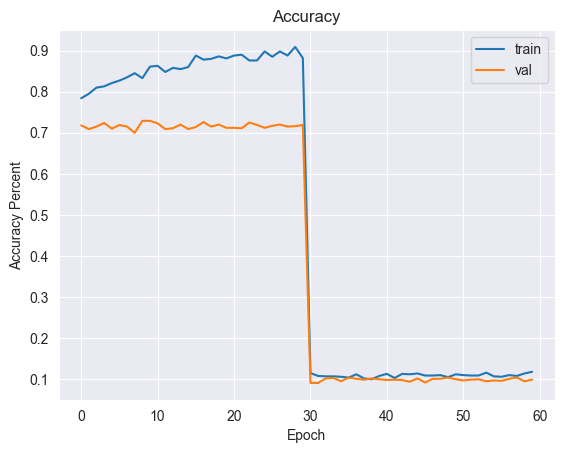

In [94]:
plt.plot([a.cpu() for a in acc_list.train], label='train')
plt.plot([a.cpu() for a in acc_list.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

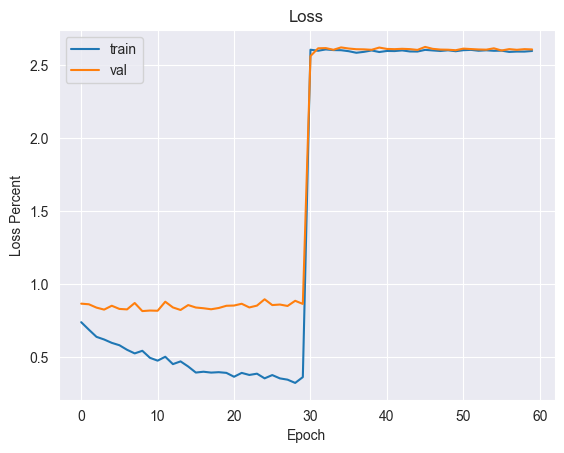

In [95]:
plt.plot([a for a in loss_list.train], label='train')
plt.plot([a for a in loss_list.val], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()

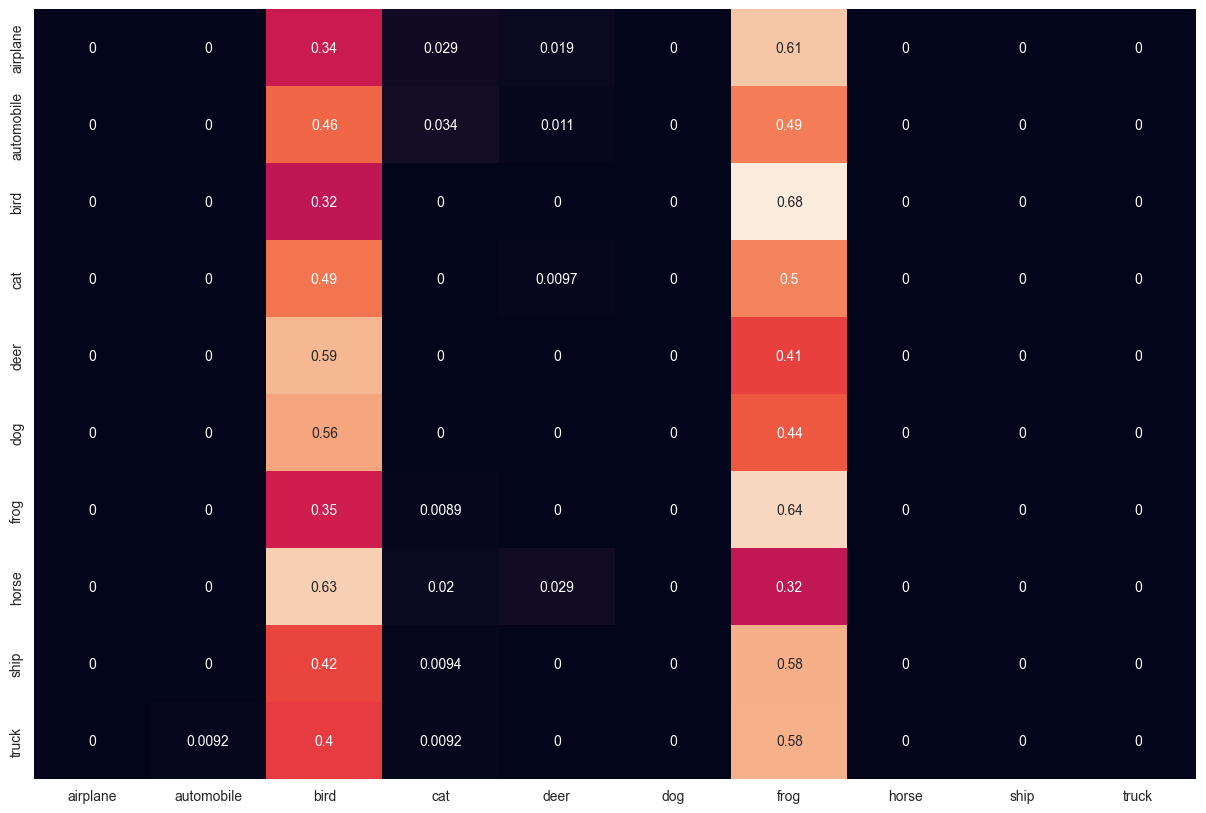

In [97]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


def plot_cm(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in hog_dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model(inputs)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cm / np.sum(cm, axis=1)[:, None],
        index=[i for i in class_names],
        columns=[i for i in class_names]
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_cm, annot=True, cbar=False)
    plt.show()


plot_cm(model)


In [98]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(hog_dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break

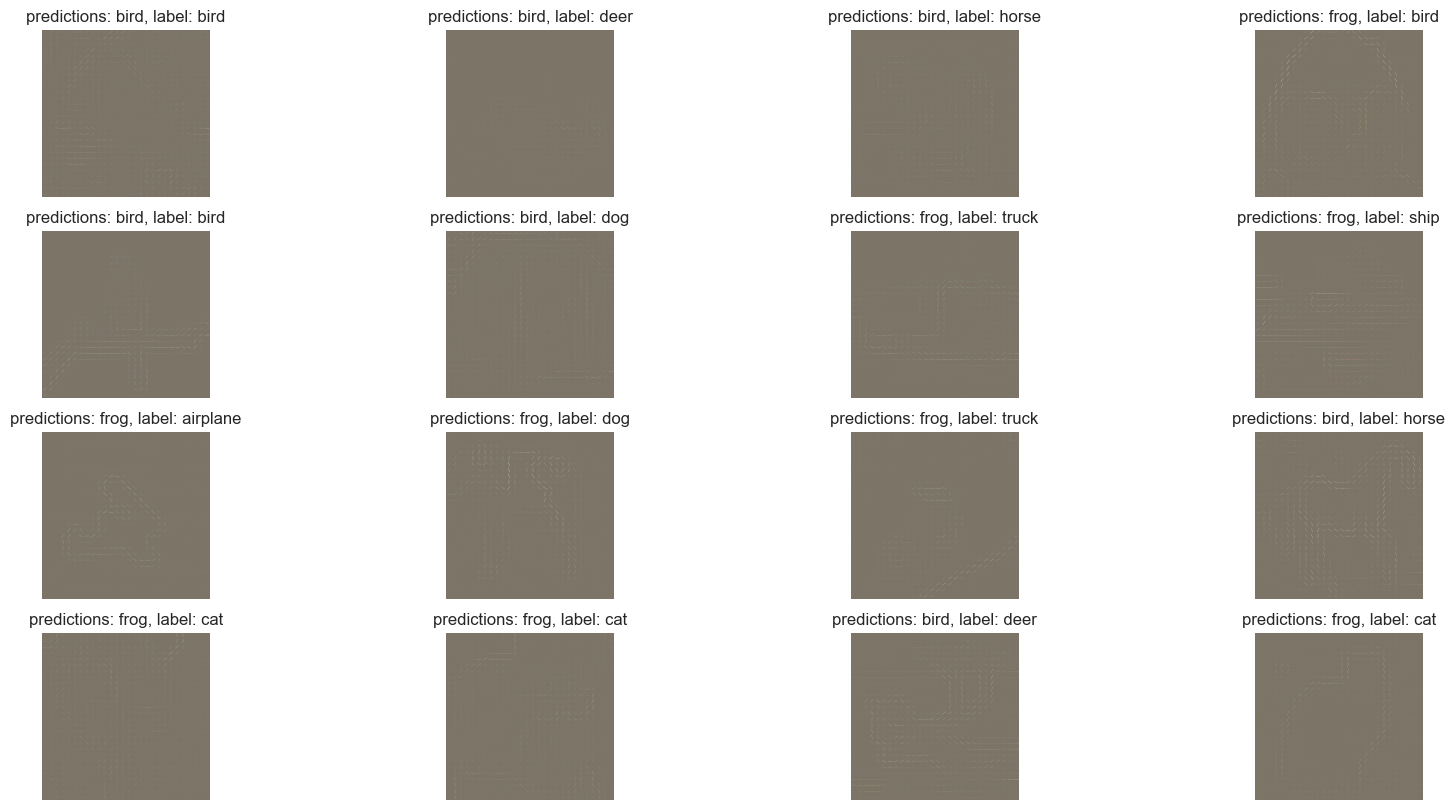

In [99]:
visualize_model(model)
